# Foreword

For the purpose of Data Science Special Syllabus Report, I am going to use the data from Robot Field for the year 2020. Following is a summary of the field and the dates when the data was collected from the field.


Date of data collections  
Subvplots in the field  
Distribution of dates in the season  
Days to heading  
Days to maturity  
Sowing dates  

# Preprocessing

In [1]:
%%time

import pandas as pd
import numpy as np
import math
import os
import datetime
from copy import copy
import pprint # pretty print
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# To display df nicely in loops
from IPython.display import display 
# display(df1.head()) 
# display(df2.head())

# Display rows and columns Pandas
pd.options.display.max_columns = 100
pd.set_option('display.max_rows',50)

Wall time: 1.15 s


In [2]:
# Prints the current workinig directory
os.getcwd()
# os.listdir()

'C:\\Users\\fahad\\Documents\\GitHub\\vPheno\\DS Special Syllabus Report\\Code'

## Importing Data

In [3]:
path = r'C:\Users\fahad\Documents\Master Thesis\Phenotyping\Data\Feb2021\Vollebekke-total_2020\Robot'
export_path = './Data/'
# os.listdir(path)

## Data Preparation and control
### Creating list of all files

In [4]:
# Get the list of all files in directory tree at given path

files_with_address = []
files_list = []

for (dirpath, dirnames, filenames) in os.walk(path):
    files_with_address += [os.path.join(dirpath, file) for file in filenames]
    files_list.extend(filenames)
    
print(len(files_with_address), 'files founnd in the directory')
# files_with_address
# files_list

18 files founnd in the directory


### Check for duplicate filenames

In [5]:
print('Total number of files are :', len(files_list))

print('Number of unique file names are:', len(set(files_list)))

print('There is/are', len(files_list)- len(set(files_list)),'duplicate file name/names.')

Total number of files are : 18
Number of unique file names are: 18
There is/are 0 duplicate file name/names.


### Checking if there are multiple sheets in the files

In [6]:
# Print number of sheets in all files
print('The following files have multiple sheets.')

list_multi_sheet = []
for file in files_with_address:
    
    xl_file = pd.ExcelFile(file,engine='openpyxl')
    number_of_sheets = len(xl_file.sheet_names)
    if number_of_sheets > 1:
        print(number_of_sheets, os.path.basename(file), 'in folder', os.path.basename(os.path.dirname(file))
)
        list_multi_sheet.append(file)

The following files have multiple sheets.
3 ROBOT_2020.xlsx in folder Robot


### Removing files with multiple sheets from the list

In [7]:
# Removing files with multiple sheets from the list

for i in list_multi_sheet:
    files_with_address.remove(i)
len(files_with_address)

17

## Importing data files to Pandas

In [8]:
%%time

all_df = []
for data in files_with_address:
    file_name = os.path.splitext(os.path.basename(data))[0]

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("(", "")
    df_name = file_name.replace(")", "")

    all_df.append(df_name)

    locals()[df_name] = pd.read_excel(data, engine='openpyxl')
    print(df_name, '=====', locals()[df_name].shape)

Robot_Mica_010720 ===== (96, 22)
Robot_Mica_040820 ===== (96, 49)
Robot_Mica_070720 ===== (96, 22)
Robot_Mica_070820 ===== (96, 97)
Robot_Mica_120820 ===== (96, 22)
Robot_Mica_130720 ===== (96, 22)
Robot_Mica_140820 ===== (96, 40)
Robot_Mica_160720 ===== (96, 19)
Robot_mica_180620 ===== (96, 49)
Robot_Mica_200720 ===== (96, 49)
Robot_Mica_220720 ===== (96, 49)
Robot_Mica_230620 ===== (96, 46)
Robot_Mica_240620 ===== (96, 49)
Robot_Mica_250620 ===== (96, 46)
Robot_Mica_270720 ===== (96, 49)
Robot_Mica_290620 ===== (96, 49)
Robot_Mica_300720 ===== (96, 22)
Wall time: 1.79 s


## Data Control: Check which df have the data column heading we need

### Listing column headings into df

In [9]:
%%time

# Finding max number of columns in all df

len_columns = []
for df in all_df:
    cols_df = locals()[df].columns
    len_columns.append(len(cols_df))
max_cols_in_df = max(len_columns)

# Now creating a empty df to collect all column headings
columns_df = pd.DataFrame(data=range(0,max_cols_in_df), columns = ['ID'])
columns_df.drop('ID', axis=1, inplace=True)

for df in all_df:
    cols_df = locals()[df].columns
    columns_df[df] = pd.Series(cols_df)


Wall time: 13 ms


### Convert columns_df to dictoionary

In [10]:
%%time

# Function to convert df to dict while dropping nan in each column separately

def comp_dropna(df1):
    return {k: v.dropna().to_dict() for k,v in df1.items()}

columns_dict = comp_dropna(columns_df)
# columns_dict

Wall time: 4.99 ms


### Finding Column heading with the text we are looking for in

In [11]:
%%time

# Find columns with key from the following list
# Rename the founc columns to the values against the keys

id_cols_var = ['id', 'plot']
id_cols_new = ['Plot_ID']


find_cols = {
    id_cols_var[0]: id_cols_new[0],
    id_cols_var[1]: id_cols_new[0],
    'Blue': 'Blue',
    'Gre': 'Green',
    'Red': 'Red',
    'RedE': 'RedEdge',
    'NIR': 'NIR',
    'NDVI': 'NDVI',
    'MTCI': 'MTCI'
}


dtype_f = {0: '_Mean_Value', 1: '_Median_Value', 2: '_Std_Dev_Value'}
num_std_dtype_colunms = len(dtype_f)

list_ok_df_per_query = []
list_problem_df_per_query = []

for query, query_f in find_cols.items():
    
    # First, we loop through all df to find the max of number of relavant columns in any df
    num_col_found_all = []
    for df, cols_dict in columns_dict.items():

        # List to save the relavant columns found in the df
        cols_found = []
        
        # Loop through all column names
        for key, item in cols_dict.items():
            
            # Check if required text is in colmn name,i.e. item
            
            # Ensure first that the text does not contain 'count' and 'sum' in it
            if item.lower().find('sum'.lower()) == -1 and item.lower().find('count'.lower()) == -1:
            
                # When searching for Red, search for red but ignore RedEdge,i.e. RedE
                if query.lower()=='red':
                    if item.lower().find(query.lower()) != -1 and item.lower().find('RedE'.lower()) == -1:
                        cols_found.append(item)

                # For the rest also checking we do not get 'GNDVI' columns. Don't neet them yet
                elif item.lower().find(query.lower()) != -1 and item.lower().find('GNDVI'.lower()) == -1:
                    cols_found.append(item)

        num_col_found_all.append(len(cols_found))
    max_cols = max(num_col_found_all)
#     print(query, max_cols)

    # Define a df for saving the columns found if num of col is not num_std_dtype_colunms
    temp_df_non_std_cols = 'col_df_non_std_cols_'+query
    
    # Add a condition in data if no columns found, then still create a df with 1 column
    locals()[temp_df_non_std_cols] = pd.DataFrame(data=range(0,max_cols) if max_cols > 1 else range(0,1),
                                                  columns = [query])
    list_problem_df_per_query.append(temp_df_non_std_cols)
    
    # Define a df for saving the columns found if num of col is num_std_dtype_colunms
    temp_df_std_cols= 'col_df_std_cols_'+query
    locals()[temp_df_std_cols] = pd.DataFrame(data=range(0,num_std_dtype_colunms), columns = [query])
    list_ok_df_per_query.append(temp_df_std_cols)
    
    
    
    # Now we again loop and append those columns to a relavant df for each query
    
    for df, cols_dict in columns_dict.items():

        # List to save the relavant columns found in the df
        cols_found = []

        # Loop through all column names
        for key, item in cols_dict.items():

            # Check if required text is in colmn name,i.e. item
            
            # Ensure first that the text does not contain 'count' and 'sum' in it
            if item.lower().find('sum'.lower()) == -1 and item.lower().find('count'.lower()) == -1 and item.lower().find('GreenND'.lower()) == -1:
            
                # When searching for Red, search for red but ignore RedEdge,i.e. RedE
                if query.lower()=='red':
                    if item.lower().find(query.lower()) != -1 and item.lower().find('RedE'.lower()) == -1:
                        cols_found.append(item)

                # For the rest also checking we do not get 'GNDVI' columns. Don't neet them yet
                elif item.lower().find(query.lower()) != -1 and item.lower().find('GNDVI'.lower()) == -1:
                    cols_found.append(item)

        # Adding the found values to a column in dataframe
        
        # For non standard columns
        if len(cols_found) != num_std_dtype_colunms and query not in id_cols_var:
            locals()[temp_df_non_std_cols][df] = pd.Series(cols_found, dtype='str')
        
        # For standrd columns
        if len(cols_found) == num_std_dtype_colunms or query in id_cols_var:
            locals()[temp_df_std_cols][df] = pd.Series(cols_found, dtype='str')
            

        if query in id_cols_var:
            num_id_cols = 0
            for temp_query in id_cols_var:
                for column in cols_dict.values():
                    if column.lower().find(temp_query.lower()) == 0:
                        num_id_cols += 1
            if num_id_cols !=1:
                if num_id_cols == 0:
                    print(query, 'Error: ID column not found in' ,df)
                else:
                    print('Error: More than one ID column found in ' ,df)
    
    # Dropping the empty query named column from the columns dataframe
    # For non standard columns
    locals()[temp_df_non_std_cols].drop(query, axis=1, inplace=True)
    # For standrd columns
    locals()[temp_df_std_cols].drop(query, axis=1, inplace=True)

    
    # Drop extra empty rows if the query is id or plot
    # Drop empty columns, where the id is different than the one being checked
    # Drop first column with 
    # Assumption: There is only one id columns in each df
    # Assumption being checked in previous loop
    if query in id_cols_var:
        locals()[temp_df_std_cols].drop([1, 2], axis=0, inplace=True)
        locals()[temp_df_std_cols].dropna(axis=1, inplace=True)
    
    
#     # ===========================Start_of_Analysis_1================================
#     # Analysis Part: Uncomment for new data
#     # Confirm if all row elements corresopnd to data aggregation types in the dict
    
    
#     agg_types_dict = {0:'mea', 1:'med', 2:'st'}
    
#     if query in id_cols_var:
#         pass
#     else:
#         for key, agg_type in agg_types_dict.items():
#             check_df = locals()[temp_df_std_cols]#.drop(query, axis=1)
#             for row_item in check_df.iloc[key].tolist():
#                 if str(row_item).lower().find(agg_type) == -1:
#                     print(row_item, key, agg_type)
                
#     print(query, locals()[temp_df_std_cols].shape)
#     display(locals()[temp_df_std_cols])
    
#     # Analysis shows that for df with num_std_dtype_colunms relavant column names; 
#     # green and RedEdge columns have naming problems where the agg_types are
#     # not the same for mea and med for some green columns
#     # and mea, med, and st for most of the RedEdge columns
#     # =============================End_of_Analysis_1================================





    # ===========================Start_of_Analysis_2================================
    # Analysis Part: Uncomment for new data
    # Renaming the column names to standard names 
    # Renaming based on the rule that the first name is mean, second is median and 
    # the third is standard deviation.
    # This assumption has been partially checked and confirmed in Analysis_1
    
    # The id column has to be dealed separately since it does not have 
    # num_std_dtype_colunms variations i.e. mean, median, and std_dev
    df_found_correct_cols = locals()[temp_df_std_cols].shape[1]
    renamed_count = 0
    if query in id_cols_var:
        for x, y in locals()[temp_df_std_cols].items():
            locals()[x].rename({y[0]: query_f}, axis=1, inplace=True)
#             print(f'Renamed {query_f} column for dataframe {x} against value {y[0]}')
            renamed_count += 1

    else:
        for x, y in locals()[temp_df_std_cols].items():
            locals()[x].rename({y[0]: query_f+dtype_f[0], y[1]: query_f+dtype_f[1],\
                                y[2]: query_f+dtype_f[2]}, axis=1, inplace=True)
#             print(f'Renamed {query_f} columns for dataframe {x}')
            renamed_count += 1
    print(f'{query_f} column renamed in {renamed_count} of {df_found_correct_cols} found dataframes')
#     display(locals()[temp_df_std_cols].shape[2])
    
    # =============================End_of_Analysis_2================================

    
    
    
    
    
    
#     # ===========================Start_of_Analysis_3================================
#     # Analysis Part: Uncomment for new data
#     # Checking the uncommon column names/combination or df with extra columns that 
#     # make finding the correct data confusing

#     print(temp_df_non_std_cols)
#     display(locals()[temp_df_non_std_cols])

#     # =============================End_of_Analysis_3================================
    




Plot_ID column renamed in 17 of 17 found dataframes
Plot_ID column renamed in 0 of 0 found dataframes
Blue column renamed in 15 of 15 found dataframes
Green column renamed in 15 of 15 found dataframes
Red column renamed in 15 of 15 found dataframes
RedEdge column renamed in 15 of 15 found dataframes
NIR column renamed in 15 of 15 found dataframes
NDVI column renamed in 15 of 15 found dataframes
MTCI column renamed in 15 of 15 found dataframes
Wall time: 168 ms


### List of df with problems

In [12]:
%%time

list_problem_df_per_query
problem_df = []
for df in list_problem_df_per_query:
    problem_df.extend(locals()[df].columns)

print(len(set(problem_df)))
problem_df = set(problem_df)
problem_df

3
Wall time: 0 ns


{'Robot_Mica_070820', 'Robot_Mica_140820', 'Robot_Mica_160720'}

## Standardise the column names
Get list of df with all required columns after implementstandard names 

### List down standard column names

In [13]:
%%time

std_columns = []
std_columns_mean = []
std_columns_median = []
std_columns_stdev = []

for key, value in find_cols.items():
    if key in id_cols_var:
        std_columns.append(value)
        std_columns_mean.append(value)
        std_columns_median.append(value)
        std_columns_stdev.append(value)

    else:
        std_columns.extend([value+y for x, y in dtype_f.items()])
        std_columns_mean.append(value+dtype_f[0])
        std_columns_median.append(value+dtype_f[1])
        std_columns_stdev.append(value+dtype_f[2])
        
std_columns.remove('Plot_ID')
std_columns_mean.remove('Plot_ID')
std_columns_median.remove('Plot_ID')
std_columns_stdev.remove('Plot_ID')

# std_columns
# std_columns_mean
# std_columns_median
# std_columns_stdev

Wall time: 0 ns


### Find df which have all the required std columns

In [14]:
%%time

complete_dataframes = []
incomplete_df = []

for df in all_df:
    df_columns = locals()[df].columns
    if (all(x in df_columns for x in std_columns)):
        complete_dataframes.append(df)
    else:
        incomplete_df.append(df)
print(f'Found {len(complete_dataframes)} complete dataframes. Can be accessed using \"complete_dataframes\" list')
print(f'Found {len(incomplete_df)} incomplete dataframes. Can be accessed using \"incomplete_df\" list')

Found 14 complete dataframes. Can be accessed using "complete_dataframes" list
Found 3 incomplete dataframes. Can be accessed using "incomplete_df" list
Wall time: 0 ns


In [15]:
# std_columns

### Standardizing the names and dropping extra columns from complete dataframes

### Creating a dictionary with all dates for a certain field for a certain year

In [16]:
%%time

elements_to_strip = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_-()."

complete_df_std = []

field_year_dict = {}

for df in complete_dataframes:
    
    # Getting date from the df name
    date1 = copy(df)

    for x in range(3):
        date1 = date1.rstrip(elements_to_strip)
        date1 = date1.lstrip(elements_to_strip)
        for c in range(3):
            date1 = date1.rstrip(elements_to_strip)
            date1 = date1.lstrip(elements_to_strip)
        date1 = date1.split('_')[0]
    
    field_name = df.split('_')[0]
    field_name = field_name.split('-')[0]

    new_df_name = field_name +'_'+date1
    
    # Drop all columns except the std columns 
    locals()[new_df_name] = locals()[df][std_columns]
    
    complete_df_std.append(new_df_name)

    
    
    # Creating a dict with all dates for a certain field for a certain year
    dict_key = field_name+'_20'+date1[-2:]
    if dict_key in field_year_dict:
        field_year_dict[dict_key].append(date1)
    else:
        field_year_dict[dict_key] = [date1]
        
#     print(date1)
complete_df_std
if len(complete_df_std) > len(set(complete_df_std)):
    print(f'Error:\nThere are {len(complete_df_std) - len(set(complete_df_std))} duplicates in the data.\n \
    Make sure no dataset has been lost because of data being separated in 2 halves on the same date')

Wall time: 9.97 ms


#### Arranging the dates in field_year_Dict in ascending order


In [17]:
%%time

sorted_field_year_dict = {}
for key, dates_list in field_year_dict.items():
    # Converting the dates to a datetime date object and sorting them in list
    sorted_dated = sorted([
        datetime.datetime.strptime(date, '%d%m%y').date()
        for date in dates_list])

    sorted_field_year_dict[key] = sorted_dated

# sorted_dated[1].strftime('%m/%d/%Y')
sorted_field_year_dict

Wall time: 0 ns


{'Robot_2020': [datetime.date(2020, 6, 18),
  datetime.date(2020, 6, 23),
  datetime.date(2020, 6, 24),
  datetime.date(2020, 6, 25),
  datetime.date(2020, 6, 29),
  datetime.date(2020, 7, 1),
  datetime.date(2020, 7, 7),
  datetime.date(2020, 7, 13),
  datetime.date(2020, 7, 20),
  datetime.date(2020, 7, 22),
  datetime.date(2020, 7, 27),
  datetime.date(2020, 7, 30),
  datetime.date(2020, 8, 4),
  datetime.date(2020, 8, 12)]}

## Dropping NAN

### Finding NAN values

In [18]:
%%time

# Finding number of missing values in each dataframe
df_with_nan = []
missing_values = False
for df in complete_df_std:
    if locals()[df].isna().sum().sum() > 0:
        print(f'Total missing values in {df} are {locals()[df].isna().sum().sum()}')
        missing_values = True
        df_with_nan.append(df)
if not missing_values:
    print('No missing value found in any dataframe')

No missing value found in any dataframe
Wall time: 9.97 ms


### ToDo:Droping NAN values
### ToDo: Update the field_year_dict and sorted_field_year_dict if some df are dropped due to NAN

In [19]:
%%time

# Finding which column has NAN values
for df in df_with_nan:
    print(locals()[df].shape, locals()[df].dropna().shape)

Wall time: 0 ns


## ToDo: Drop duplicate plots in the datasets


## Find grain yield, DH, DT etc values and attach to the dataframes

In [20]:
# Files dropped in the initial stage
list_multi_sheet

['C:\\Users\\fahad\\Documents\\Master Thesis\\Phenotyping\\Data\\Feb2021\\Vollebekke-total_2020\\Robot\\ROBOT_2020.xlsx']

In [21]:
%%time

df_yield = []

for data in list_multi_sheet:
    file_name = os.path.splitext(os.path.basename(data))[0]

#     # Parent dir
#     dir1_name = os.path.basename(os.path.dirname(data))
#     # grand parent dir
#     dir2_name = os.path.basename(os.path.dirname(os.path.dirname(data)))

    # Replce all invalid characters in the name
    file_name = file_name.replace(" ", "_")
    file_name = file_name.replace("(", "")
    file_name = file_name.replace(")", "")

    xl_file = pd.ExcelFile(data,engine='openpyxl')
    for sheet in xl_file.sheet_names:
        df_name = file_name+'_'+sheet
        df_yield.append(df_name)
        print(df_name)
        
        locals()[df_name] = pd.read_excel(data, sheet_name=sheet, engine='openpyxl')


ROBOT_2020_raw
ROBOT_2020_lsmeans_EntryRobot_x_Fert
ROBOT_2020_layout
Wall time: 147 ms


In [22]:
ROBOT_2020_raw

,Name,CodeName,EntryRobot,Masbasis2015ID,YearOfRelease,Location,Season,class,Fertilization,SpatialRute,SpatialRep,SpatialBlock,SpatialCol,SpatialRow,PH_M_cm,Hd_date_jd,Mat_date_jd,Hd_dto_day,Mat_dto_day,GY_Calc_gm2,GW_M_g1000grn,TestWt_M_gl,GProt_NIRS_pct,BiomassAnthesisDry_Calc_gm2,BiomassMaturityDry_Calc_gm2,HarvestIndex_Calc,SpikesPerSquareMeter_M,BiomassAnthesisFresh_Calc_kgm2,BiomassMaturityFresh_Calc_kgm2
0,Avle,NaN,20,1009,1996.0,vollebekk,2020,1,80_kgN_ha,1101,1,1,1,1,71.67,2020-06-21,2020-08-07,62,109,453.658537,35.012594,79.12,10.4,570,1130,0.401468,993,2.22,1.44
1,NaN,GN10637,14,1588,NaN,vollebekk,2020,1,80_kgN_ha,1102,1,1,1,2,71.67,2020-06-21,2020-08-11,62,113,439.024390,36.604775,81.84,10.4,580,1170,0.375235,924,2.11,1.50
2,Runar,NaN,22,1020,1972.0,vollebekk,2020,1,80_kgN_ha,1103,1,1,1,3,81.67,2020-06-19,2020-08-04,60,106,409.756098,40.920097,80.92,10.7,610,1140,0.359435,751,1.97,1.33
3,Betong,GN13618,10,1592,2019.0,vollebekk,2020,1,80_kgN_ha,1104,1,1,1,4,76.67,2020-06-20,2020-08-08,61,110,474.796748,39.847716,79.76,10.8,610,1240,0.382901,988,2.18,1.62
4,Reno,NaN,23,1425,1975.0,vollebekk,2020,1,80_kgN_ha,1105,1,1,1,5,88.33,2020-06-20,2020-08-04,61,106,411.382114,36.626506,81.28,10.6,580,1200,0.342818,648,2.03,1.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Rabagast,GN07501,6,1402,2013.0,vollebekk,2020,0,80_kgN_ha,1808,2,8,8,8,61.67,2020-06-20,2020-08-03,61,105,429.268293,35.407725,79.80,11.6,640,1120,0.383275,1192,2.24,1.44
92,Runar,NaN,22,1020,1972.0,vollebekk,2020,0,80_kgN_ha,1809,2,8,8,9,78.33,2020-06-19,2020-07-31,60,102,414.634146,39.861751,81.60,11.4,730,1090,0.380398,791,2.14,1.29
93,Krabat,GN03509,4,1174,2010.0,vollebekk,2020,0,80_kgN_ha,1810,2,8,8,10,66.67,2020-06-21,2020-08-05,62,107,460.162602,38.025210,80.00,10.9,660,1130,0.407224,1085,2.34,1.50
94,Tjalve,NaN,19,1006,1987.0,vollebekk,2020,0,80_kgN_ha,1811,2,8,8,11,71.67,2020-06-21,2020-08-03,62,105,443.902439,37.795276,79.68,11.2,640,1110,0.399912,892,2.31,1.41


In [23]:
%%time

field = 'Robot_2020'
field_plot_id = 'Plot_ID'
ref_df_yield = ROBOT_2020_raw
red_df_id = 'SpatialRute'

cols2add_dict = {'GrainYield':'GY_Calc_gm2',
#                    'Maturity':
                   'Days2Heading':'Hd_dto_day',
                   'Days2Maturity':'Mat_dto_day'}

df_w_yields = []
for date in field_year_dict[field]:
    temp_df = locals()[field[:-4]+date].copy()
    temp_ref_df = ref_df_yield.copy()
    
    temp_df.set_index(field_plot_id, inplace=True)
    temp_ref_df.set_index(red_df_id, inplace=True)
    for field_df_col, ref_df_col in cols2add_dict.items():
        temp_df[field_df_col]=temp_ref_df[ref_df_col]
    new_df_name = field[:-4]+date+'_yield'
    locals()[new_df_name] = temp_df.reset_index()
    df_w_yields.append(new_df_name)
    print(new_df_name)
#     display(locals()[new_df_name])

Robot_010720_yield
Robot_040820_yield
Robot_070720_yield
Robot_120820_yield
Robot_130720_yield
Robot_180620_yield
Robot_200720_yield
Robot_220720_yield
Robot_230620_yield
Robot_240620_yield
Robot_250620_yield
Robot_270720_yield
Robot_290620_yield
Robot_300720_yield
Wall time: 42.9 ms


# Exporting with same number of columns

## Add date column

In [24]:
%%time
date_col = 'Date'

list_df_w_dates = []

for df in df_w_yields:
    new_df_name = df + '_date'
    date1 = new_df_name.split('_')[1]
    
    temp_df = locals()[df].copy()
    temp_df[date_col]=pd.to_datetime(date1, format = '%d%m%y')

    list_df_w_dates.append(new_df_name)
    locals()[new_df_name] = temp_df.copy()
    print(new_df_name, date1, temp_df.shape, pd.to_datetime(date1, format = '%d%m%y'))

Robot_010720_yield_date 010720 (96, 26) 2020-07-01 00:00:00
Robot_040820_yield_date 040820 (96, 26) 2020-08-04 00:00:00
Robot_070720_yield_date 070720 (96, 26) 2020-07-07 00:00:00
Robot_120820_yield_date 120820 (96, 26) 2020-08-12 00:00:00
Robot_130720_yield_date 130720 (96, 26) 2020-07-13 00:00:00
Robot_180620_yield_date 180620 (96, 26) 2020-06-18 00:00:00
Robot_200720_yield_date 200720 (96, 26) 2020-07-20 00:00:00
Robot_220720_yield_date 220720 (96, 26) 2020-07-22 00:00:00
Robot_230620_yield_date 230620 (96, 26) 2020-06-23 00:00:00
Robot_240620_yield_date 240620 (96, 26) 2020-06-24 00:00:00
Robot_250620_yield_date 250620 (96, 26) 2020-06-25 00:00:00
Robot_270720_yield_date 270720 (96, 26) 2020-07-27 00:00:00
Robot_290620_yield_date 290620 (96, 26) 2020-06-29 00:00:00
Robot_300720_yield_date 300720 (96, 26) 2020-07-30 00:00:00
Wall time: 35.9 ms


## Conct all df into one and export to csv

In [25]:
%%time

final_columns = locals()[list_df_w_dates[0]].columns

# Contaconating all dataframes into one for selecred final_columns

data_frames = []
for i in list_df_w_dates:
    data_frames.append(locals()[i][final_columns])


final_df = pd.concat(data_frames, ignore_index=True)

temp_filename = list_df_w_dates[0].split('_')[0]+'_fixed_cols.csv'

final_df.to_csv(export_path+temp_filename, index=False)


Wall time: 87.8 ms


# Exporting with adding features as more columns

In [26]:
%%time

general_col_names = ['Plot_ID', 'Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI']
yield_cols = ['GrainYield']

df_all_mean = []
df_all_median = []
df_all_stdev = []

for df in df_w_yields:
    temp_mean_df = df+'_mean'
    temp_median_df = df+'_median'
    temp_stdev_df = df+'_stdev'
    # Filtering columns for each type
    locals()[temp_mean_df] = locals()[df][std_columns_mean+yield_cols]
    locals()[temp_median_df] = locals()[df][std_columns_median+yield_cols]
    locals()[temp_stdev_df] = locals()[df][std_columns_stdev+yield_cols]

    # Renaming column names to general names for all
    locals()[temp_mean_df].columns = general_col_names+yield_cols

    locals()[temp_median_df].columns = general_col_names+yield_cols
    locals()[temp_stdev_df].columns = general_col_names+yield_cols
    

    df_all_mean.append(temp_mean_df)
    df_all_median.append(temp_median_df)
    df_all_stdev.append(temp_stdev_df)

final_df = df_all_mean + df_all_median + df_all_stdev


Wall time: 30.9 ms


# Extract the date from the name of df

In [27]:
%%time
date_col = 'Date'

list_df_w_dates = []

for df in final_df:
    new_df_name = df + '_full'
    
    temp_df = locals()[df].copy()
    temp_df[date_col]=pd.to_datetime(date1, format = '%d%m%y')

    
    list_df_w_dates.append(new_df_name)
    locals()[new_df_name] = temp_df.copy()

Wall time: 67.8 ms


In [28]:
len(list_df_w_dates)
# list_df_w_dates
list_df_w_dates

['Robot_010720_yield_mean_full',
 'Robot_040820_yield_mean_full',
 'Robot_070720_yield_mean_full',
 'Robot_120820_yield_mean_full',
 'Robot_130720_yield_mean_full',
 'Robot_180620_yield_mean_full',
 'Robot_200720_yield_mean_full',
 'Robot_220720_yield_mean_full',
 'Robot_230620_yield_mean_full',
 'Robot_240620_yield_mean_full',
 'Robot_250620_yield_mean_full',
 'Robot_270720_yield_mean_full',
 'Robot_290620_yield_mean_full',
 'Robot_300720_yield_mean_full',
 'Robot_010720_yield_median_full',
 'Robot_040820_yield_median_full',
 'Robot_070720_yield_median_full',
 'Robot_120820_yield_median_full',
 'Robot_130720_yield_median_full',
 'Robot_180620_yield_median_full',
 'Robot_200720_yield_median_full',
 'Robot_220720_yield_median_full',
 'Robot_230620_yield_median_full',
 'Robot_240620_yield_median_full',
 'Robot_250620_yield_median_full',
 'Robot_270720_yield_median_full',
 'Robot_290620_yield_median_full',
 'Robot_300720_yield_median_full',
 'Robot_010720_yield_stdev_full',
 'Robot_040820

# Visualisation
## Create Separate df for each index for data plotting
### ToDo: Print Grain Yield as well¶

<timed exec>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Wall time: 3.66 s


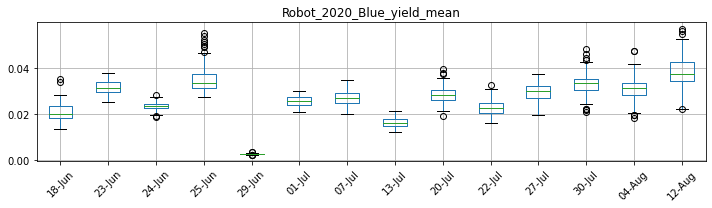

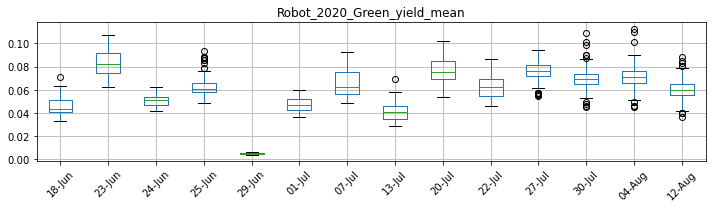

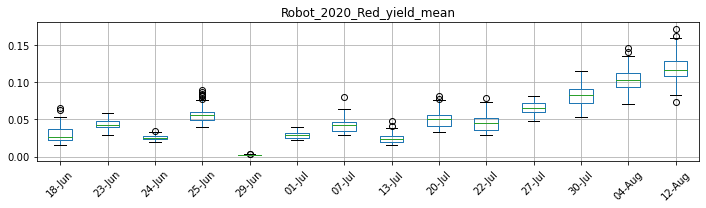

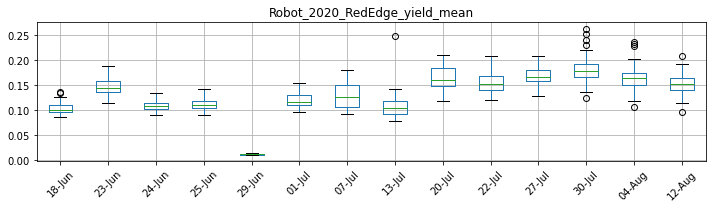

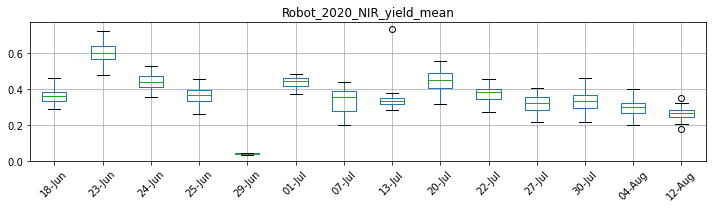

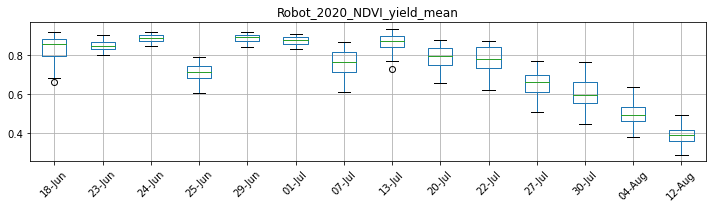

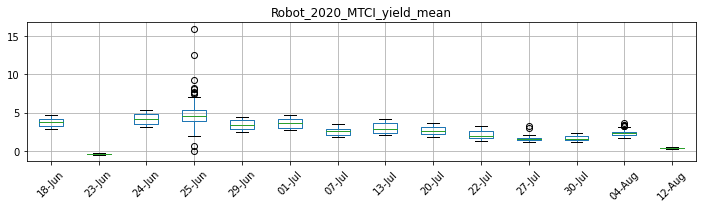

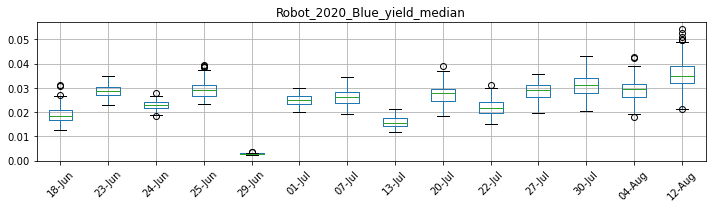

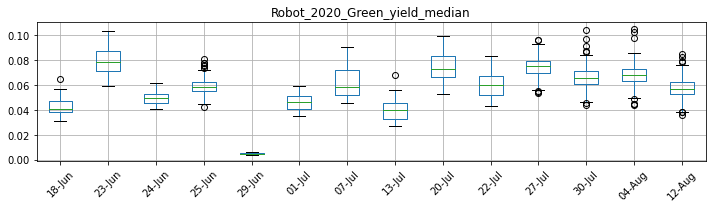

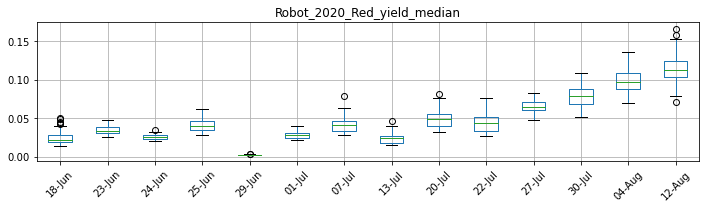

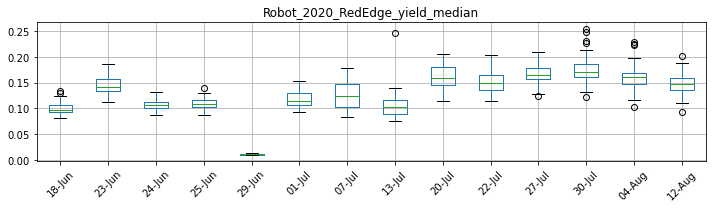

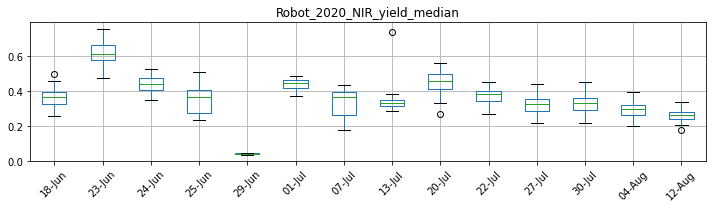

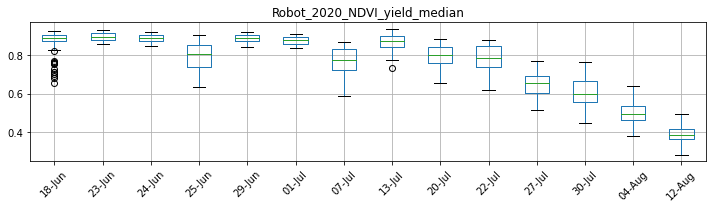

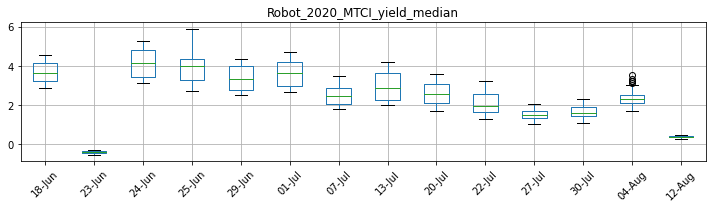

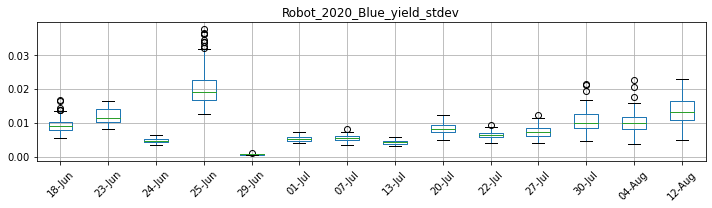

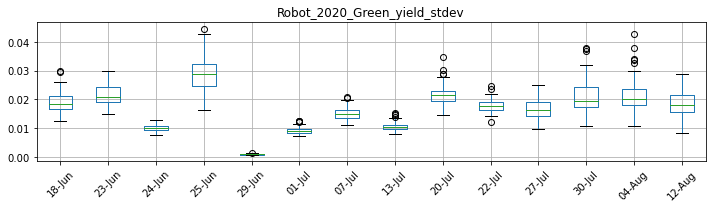

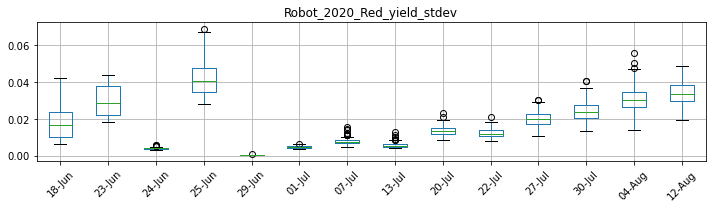

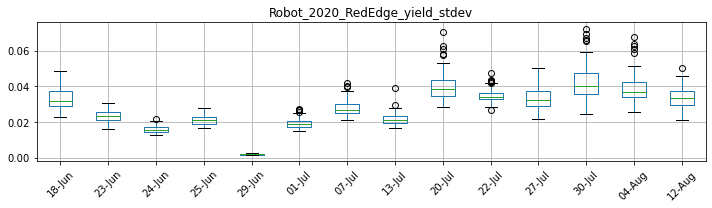

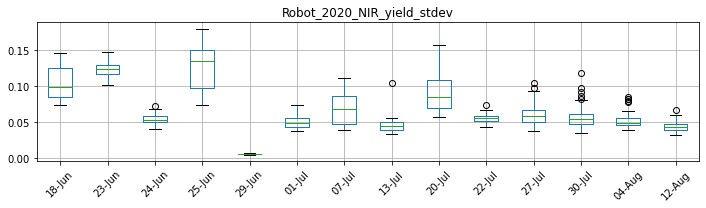

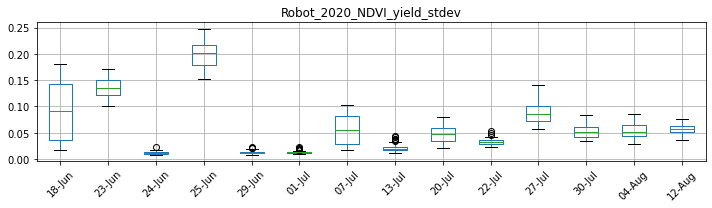

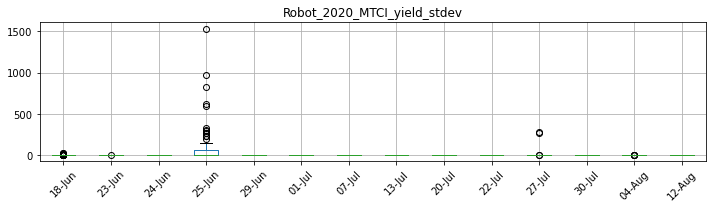

In [29]:
%%time

base_indices = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI']
# yield_cols = ['GrainYield']

data_agg_list = ['_yield_mean_full', '_yield_median_full', '_yield_stdev_full']
# base_indices = general_col_names[1:]

# base_indices = ['Blue']
# base_indices = ['Green']
# base_indices = ['Red']
# base_indices = ['RedEdge']
# base_indices = ['NIR']
# base_indices = ['NDVI']
# base_indices = ['MTCI']

for d_type in data_agg_list:
    for col in base_indices:
        fields = len(sorted_field_year_dict.keys())
        rows = math.ceil(fields/2)
        fig_size=(10,3)
        n_plot = 0
        
        if fields < 2:
            columns = 1
            fig, ax = plt.subplots(rows,columns, figsize=fig_size)
            plots = [ax]
        else:
            columns = 2
            fig, ax = plt.subplots(rows,columns, figsize=fig_size)
            plots = ax.flatten()
            
        for field_sample, dates in sorted_field_year_dict.items():
            
            # Adding required data to a temp dataframe
            temp_df = pd.DataFrame()
            for date in dates:
                date_str = date.strftime('%d%m%y')
                field_df = field_sample[:-5]+'_'+date_str+d_type
                col_name = date.strftime('%d-%b')+'_'+col
                temp_df[col_name] = locals()[field_df][col]
            
            # Adding field plot to the subplots
            
            ax_n = plots[n_plot]
            x_labels = [date[:-(len(col)+1)] for date in temp_df.columns.tolist()]
            temp_df.boxplot(ax=ax_n)

            ax_n.set_xticklabels(x_labels, rotation=45)
            ax_n.set_title(field_sample+'_'+col+d_type[:-5])
            
#             # Printing the grain yield in plot of the fiels_sample for reference
#             text = "Grain Yield"
#             ax_n.text(0.85, 1.05, text, ha='center', va='top', weight='bold', color='blue', transform=ax_n.transAxes)

            n_plot += 1
        plt.tight_layout()

# Merge data at plots

In [30]:
d_type

'_yield_stdev_full'

In [31]:
%%time

# data_agg_list = ['_yield_median_full']
# yield_cols = ['GrainYield']

list_agg_df = []
for d_type in data_agg_list:
    
    for field_sample, dates in sorted_field_year_dict.items():

        # Adding required data to a temp dataframe
        temp_df_all = field_sample+d_type+"_fix_rows"
        locals()[temp_df_all] = pd.DataFrame()
        for date in dates:
            date_str = date.strftime('%d%m%y')
            field_df = field_sample[:-5]+'_'+date_str+d_type
#             print(field_df)
            temp_df = locals()[field_df].copy()
            temp_df.columns = ['Plot_ID']+[x+'_'+date_str for x in temp_df.columns[1:]]
            
#             # Checking if the merge is correct if the rows are randomized
#             temp_df = temp_df.sample(frac=1).reset_index(drop=True)
#             display(temp_df)

            # Dropping Date Column as it is not necessary since date imformation is moved to column headings
            temp_df.drop(columns=[date_col+'_'+date_str], inplace=True)
        
            if locals()[temp_df_all].shape[1] <5:
                locals()[temp_df_all] = temp_df.copy()
#                 display(temp_df)

            else:
                # Dropping grain yield columns to avoid duplication
                for col in yield_cols:
                    temp_df.drop(columns=[col+'_'+date_str], inplace=True)
                
                # Merging dataframes
#                 locals()[temp_df_all] = pd.concat([locals()[temp_df_all].set_index('Plot_ID'),temp_df.set_index('Plot_ID')], axis=1, join='inner').reset_index()
                locals()[temp_df_all] = locals()[temp_df_all].merge(temp_df, on='Plot_ID', how='left', suffixes=('', date_str))
#                 locals()[temp_df_all] = locals()[temp_df_all].join(temp_df, on='Plot_ID', lsuffix='', rsuffix='_right')

#                 display(locals()[temp_df_all])

        list_agg_df.append(temp_df_all)  
        print(temp_df_all)
        display(locals()[temp_df_all])
        
        # Exporting the data to csv file
        locals()[temp_df_all].to_csv(export_path+field_sample+'_'+d_type.split('_')[2]+'_fixed_rows'+'.csv', index=False)


Robot_2020_yield_mean_full_fix_rows


,Plot_ID,Blue_180620,Green_180620,Red_180620,RedEdge_180620,NIR_180620,NDVI_180620,MTCI_180620,GrainYield_180620,Blue_230620,Green_230620,Red_230620,RedEdge_230620,NIR_230620,NDVI_230620,MTCI_230620,Blue_240620,Green_240620,Red_240620,RedEdge_240620,NIR_240620,NDVI_240620,MTCI_240620,Blue_250620,Green_250620,Red_250620,RedEdge_250620,NIR_250620,NDVI_250620,MTCI_250620,Blue_290620,Green_290620,Red_290620,RedEdge_290620,NIR_290620,NDVI_290620,MTCI_290620,Blue_010720,Green_010720,Red_010720,RedEdge_010720,NIR_010720,NDVI_010720,MTCI_010720,Blue_070720,Green_070720,Red_070720,RedEdge_070720,NIR_070720,NDVI_070720,MTCI_070720,Blue_130720,Green_130720,Red_130720,RedEdge_130720,NIR_130720,NDVI_130720,MTCI_130720,Blue_200720,Green_200720,Red_200720,RedEdge_200720,NIR_200720,NDVI_200720,MTCI_200720,Blue_220720,Green_220720,Red_220720,RedEdge_220720,NIR_220720,NDVI_220720,MTCI_220720,Blue_270720,Green_270720,Red_270720,RedEdge_270720,NIR_270720,NDVI_270720,MTCI_270720,Blue_300720,Green_300720,Red_300720,RedEdge_300720,NIR_300720,NDVI_300720,MTCI_300720,Blue_040820,Green_040820,Red_040820,RedEdge_040820,NIR_040820,NDVI_040820,MTCI_040820,Blue_120820,Green_120820,Red_120820,RedEdge_120820,NIR_120820,NDVI_120820,MTCI_120820
0,1101,0.023117,0.049997,0.041891,0.106386,0.303060,0.742998,3.236652,453.658537,0.034658,0.101610,0.053500,0.164664,0.628276,0.833159,-0.425224,0.019409,0.050783,0.024881,0.114441,0.405089,0.883523,3.260584,0.031153,0.064236,0.055318,0.124388,0.346428,0.700746,3.123065,0.002484,0.005341,0.002470,0.013745,0.043033,0.891073,2.618574,0.022459,0.052765,0.028500,0.144346,0.467603,0.884827,2.815468,0.027073,0.078734,0.061178,0.163610,0.366924,0.712901,2.017144,0.018957,0.069283,0.024114,0.248385,0.737871,0.936160,2.200701,0.025615,0.082916,0.053052,0.184504,0.454286,0.786901,2.080037,0.020260,0.069212,0.048744,0.180395,0.398666,0.783587,1.686128,0.026805,0.070147,0.069384,0.156602,0.295468,0.618893,1.703410,0.027121,0.060793,0.072478,0.195749,0.416662,0.692292,1.751466,0.021705,0.058585,0.082878,0.151758,0.303641,0.575958,2.229074,0.023765,0.044861,0.094338,0.136815,0.274839,0.493403,0.493403
1,1102,0.026724,0.054805,0.048903,0.112795,0.307741,0.704649,3.266962,439.024390,0.029759,0.089300,0.047848,0.162189,0.577202,0.840612,-0.470646,0.024906,0.055513,0.030752,0.118029,0.407340,0.859169,3.322398,0.034238,0.065624,0.058902,0.126826,0.340488,0.683152,3.306180,0.003232,0.005787,0.003036,0.013897,0.042184,0.865584,2.622602,0.028519,0.056449,0.035211,0.145996,0.460994,0.857613,2.861839,0.024407,0.079632,0.043544,0.169809,0.409833,0.807108,1.919936,0.019449,0.052086,0.030697,0.136400,0.362856,0.844090,2.165171,0.032198,0.092769,0.064164,0.192405,0.444433,0.743792,1.984863,0.026929,0.078100,0.060022,0.188535,0.391677,0.734819,1.606498,0.025322,0.072655,0.061694,0.167858,0.316334,0.671287,1.430025,0.036887,0.077297,0.091216,0.197945,0.359721,0.598847,1.540047,0.033582,0.079769,0.105791,0.176919,0.318350,0.505863,2.016544,0.037023,0.064577,0.116817,0.165510,0.295897,0.439086,0.439086
2,1103,0.028235,0.057500,0.053666,0.117416,0.318344,0.693748,3.453961,409.756098,0.034707,0.094744,0.053855,0.163373,0.577329,0.822017,-0.476526,0.022820,0.053220,0.029111,0.115883,0.409586,0.866582,3.397225,0.034212,0.065105,0.060746,0.121366,0.335088,0.674892,3.425750,0.003115,0.005830,0.002940,0.014143,0.042853,0.871484,2.584014,0.027263,0.057720,0.034694,0.150859,0.470922,0.862241,2.774859,0.031470,0.087693,0.053007,0.174978,0.409116,0.770284,1.936060,0.018560,0.052030,0.032928,0.130198,0.343185,0.824951,2.220277,0.032600,0.093506,0.070787,0.195014,0.441239,0.718484,2.008339,0.026903,0.077226,0.063836,0.187044,0.382620,0.715003,1.616288,0.031314,0.081324,0.071948,0.175330,0.310795,0.624159,1.337127,0.033340,0.075764,0.090016,0.192273,0.330950,0.575847,1.389017,0.034347,0.082482,0.119128,0.186582,0.324579,0.468814,2.068123,0.042675,0.071174,0.135625,0.177150,0.307185,0.395726,0.395726
3,1104,0.023126,0.046959,0.038596,0.099814,0.290042,0.750203,3.313

Robot_2020_yield_median_full_fix_rows


,Plot_ID,Blue_180620,Green_180620,Red_180620,RedEdge_180620,NIR_180620,NDVI_180620,MTCI_180620,GrainYield_180620,Blue_230620,Green_230620,Red_230620,RedEdge_230620,NIR_230620,NDVI_230620,MTCI_230620,Blue_240620,Green_240620,Red_240620,RedEdge_240620,NIR_240620,NDVI_240620,MTCI_240620,Blue_250620,Green_250620,Red_250620,RedEdge_250620,NIR_250620,NDVI_250620,MTCI_250620,Blue_290620,Green_290620,Red_290620,RedEdge_290620,NIR_290620,NDVI_290620,MTCI_290620,Blue_010720,Green_010720,Red_010720,RedEdge_010720,NIR_010720,NDVI_010720,MTCI_010720,Blue_070720,Green_070720,Red_070720,RedEdge_070720,NIR_070720,NDVI_070720,MTCI_070720,Blue_130720,Green_130720,Red_130720,RedEdge_130720,NIR_130720,NDVI_130720,MTCI_130720,Blue_200720,Green_200720,Red_200720,RedEdge_200720,NIR_200720,NDVI_200720,MTCI_200720,Blue_220720,Green_220720,Red_220720,RedEdge_220720,NIR_220720,NDVI_220720,MTCI_220720,Blue_270720,Green_270720,Red_270720,RedEdge_270720,NIR_270720,NDVI_270720,MTCI_270720,Blue_300720,Green_300720,Red_300720,RedEdge_300720,NIR_300720,NDVI_300720,MTCI_300720,Blue_040820,Green_040820,Red_040820,RedEdge_040820,NIR_040820,NDVI_040820,MTCI_040820,Blue_120820,Green_120820,Red_120820,RedEdge_120820,NIR_120820,NDVI_120820,MTCI_120820
0,1101,0.020172,0.045518,0.031956,0.104009,0.291076,0.752425,3.156992,453.658537,0.031525,0.098336,0.042261,0.162172,0.634124,0.881080,-0.406316,0.018872,0.049369,0.024608,0.112616,0.402543,0.885614,3.262092,0.028579,0.065614,0.046904,0.121527,0.294172,0.724423,2.949702,0.002445,0.005291,0.002453,0.013643,0.042929,0.891991,2.608521,0.021905,0.051635,0.028147,0.142298,0.465755,0.885390,2.803551,0.026941,0.078043,0.059719,0.163123,0.365088,0.713755,1.996877,0.018340,0.067697,0.023631,0.246153,0.735899,0.937665,2.195285,0.024546,0.082166,0.051452,0.182917,0.459972,0.802431,2.067497,0.019306,0.066392,0.047035,0.176781,0.394213,0.787492,1.685444,0.025022,0.068829,0.069010,0.153430,0.289067,0.602283,1.577007,0.025994,0.058859,0.070486,0.190948,0.377660,0.675071,1.651821,0.020950,0.056335,0.080090,0.148009,0.298842,0.577323,2.229380,0.023059,0.043694,0.092061,0.134482,0.271711,0.493603,0.493603
1,1102,0.024764,0.052079,0.042080,0.110786,0.262999,0.711122,3.191882,439.024390,0.025550,0.084070,0.036522,0.161120,0.577145,0.886249,-0.457174,0.024412,0.054661,0.030559,0.117232,0.405762,0.860194,3.320230,0.032563,0.066505,0.050314,0.125360,0.285351,0.702292,3.120023,0.003207,0.005747,0.003020,0.013781,0.041950,0.866511,2.609107,0.028108,0.055910,0.035009,0.145149,0.458687,0.858816,2.861652,0.024079,0.078848,0.043090,0.169368,0.410774,0.809001,1.904274,0.019176,0.051398,0.030258,0.135311,0.361238,0.845886,2.162522,0.031326,0.091255,0.063361,0.189308,0.447530,0.757654,1.983066,0.026521,0.076623,0.059252,0.186323,0.388483,0.736908,1.595386,0.023936,0.071961,0.061892,0.167060,0.320667,0.670205,1.389728,0.035946,0.075253,0.089332,0.194962,0.356104,0.598632,1.530140,0.033042,0.078066,0.103323,0.174171,0.314360,0.505865,2.004309,0.036107,0.063297,0.114168,0.163317,0.293184,0.438583,0.438583
2,1103,0.026465,0.054017,0.044348,0.115718,0.288947,0.689330,3.297433,409.756098,0.030679,0.089906,0.041425,0.159434,0.584293,0.871417,-0.455954,0.022245,0.051949,0.028875,0.114271,0.405203,0.867228,3.399008,0.032495,0.067392,0.050833,0.119320,0.276945,0.701138,3.252448,0.003069,0.005775,0.002918,0.014036,0.042714,0.872110,2.577875,0.026808,0.057188,0.034401,0.149912,0.468715,0.863303,2.768063,0.030525,0.086063,0.052053,0.173426,0.406994,0.771058,1.924152,0.018139,0.050881,0.031845,0.128981,0.341398,0.828005,2.213250,0.031893,0.092441,0.069187,0.193583,0.447553,0.731309,1.996397,0.026254,0.075286,0.061872,0.184004,0.377727,0.716029,1.594675,0.031164,0.079833,0.075282,0.175131,0.313341,0.604588,1.307645,0.032218,0.073112,0.087587,0.187502,0.325618,0.576930,1.385242,0.033037,0.079752,0.115401,0.182299,0.318903,0.469141,2.061569,0.039928,0.068010,0.130763,0.173318,0.302046,0.396589,0.396589
3,1104,0.020741,0.040924,0.029859,0.093343,0.255354,0.757378,3.221

Robot_2020_yield_stdev_full_fix_rows


,Plot_ID,Blue_180620,Green_180620,Red_180620,RedEdge_180620,NIR_180620,NDVI_180620,MTCI_180620,GrainYield_180620,Blue_230620,Green_230620,Red_230620,RedEdge_230620,NIR_230620,NDVI_230620,MTCI_230620,Blue_240620,Green_240620,Red_240620,RedEdge_240620,NIR_240620,NDVI_240620,MTCI_240620,Blue_250620,Green_250620,Red_250620,RedEdge_250620,NIR_250620,NDVI_250620,MTCI_250620,Blue_290620,Green_290620,Red_290620,RedEdge_290620,NIR_290620,NDVI_290620,MTCI_290620,Blue_010720,Green_010720,Red_010720,RedEdge_010720,NIR_010720,NDVI_010720,MTCI_010720,Blue_070720,Green_070720,Red_070720,RedEdge_070720,NIR_070720,NDVI_070720,MTCI_070720,Blue_130720,Green_130720,Red_130720,RedEdge_130720,NIR_130720,NDVI_130720,MTCI_130720,Blue_200720,Green_200720,Red_200720,RedEdge_200720,NIR_200720,NDVI_200720,MTCI_200720,Blue_220720,Green_220720,Red_220720,RedEdge_220720,NIR_220720,NDVI_220720,MTCI_220720,Blue_270720,Green_270720,Red_270720,RedEdge_270720,NIR_270720,NDVI_270720,MTCI_270720,Blue_300720,Green_300720,Red_300720,RedEdge_300720,NIR_300720,NDVI_300720,MTCI_300720,Blue_040820,Green_040820,Red_040820,RedEdge_040820,NIR_040820,NDVI_040820,MTCI_040820,Blue_120820,Green_120820,Red_120820,RedEdge_120820,NIR_120820,NDVI_120820,MTCI_120820
0,1101,0.010470,0.023923,0.026214,0.045147,0.134582,0.129318,0.850809,453.658537,0.013089,0.023496,0.034593,0.025217,0.126449,0.132792,0.147785,0.003513,0.009614,0.003174,0.015487,0.050894,0.014121,0.231310,0.013016,0.022666,0.028310,0.023590,0.139032,0.154667,0.661552,0.000493,0.000948,0.000363,0.001977,0.005167,0.012987,0.237571,0.004297,0.009473,0.004371,0.021075,0.053853,0.014203,0.255095,0.004181,0.013901,0.009840,0.024792,0.048726,0.038037,0.207312,0.004417,0.014509,0.004644,0.039045,0.103534,0.011936,0.253477,0.006616,0.015240,0.011614,0.030018,0.072187,0.060776,0.239574,0.005468,0.017565,0.011907,0.034297,0.056030,0.031563,0.174551,0.007110,0.014281,0.020824,0.030082,0.048197,0.095567,0.542299,0.006620,0.012462,0.013853,0.036068,0.117229,0.066753,0.339071,0.004971,0.013578,0.019217,0.027490,0.039913,0.037374,0.210466,0.005006,0.008483,0.019252,0.021141,0.031320,0.035667,0.035667
1,1102,0.009883,0.024970,0.024635,0.048510,0.146224,0.129508,0.590206,439.024390,0.013844,0.024381,0.035853,0.019603,0.104479,0.133979,0.126364,0.004134,0.008463,0.003264,0.012959,0.043971,0.011266,0.173305,0.013839,0.024590,0.029191,0.019872,0.141358,0.152324,0.724583,0.000629,0.000983,0.000440,0.001926,0.004960,0.013304,0.212932,0.005220,0.008966,0.004360,0.019667,0.054826,0.012931,0.215243,0.004195,0.013929,0.006810,0.024791,0.051302,0.025419,0.185151,0.004188,0.010432,0.005428,0.021408,0.045165,0.018972,0.192825,0.006963,0.016483,0.011263,0.029983,0.071184,0.056149,0.221337,0.005727,0.016746,0.011620,0.032491,0.053192,0.030941,0.166928,0.006382,0.012444,0.016543,0.025839,0.048064,0.086237,0.219811,0.008743,0.017331,0.019604,0.034325,0.044841,0.039357,0.192978,0.007277,0.017087,0.023100,0.031070,0.041044,0.038644,0.217931,0.008658,0.013014,0.024825,0.026706,0.035577,0.039922,0.039922
2,1103,0.011484,0.025449,0.030844,0.047242,0.138887,0.153152,1.261982,409.756098,0.013972,0.023082,0.036775,0.026102,0.101493,0.138572,0.126325,0.004011,0.009231,0.003002,0.014679,0.050212,0.011151,0.186045,0.014879,0.025047,0.032191,0.021241,0.140465,0.163140,0.731106,0.000645,0.001030,0.000425,0.002055,0.005111,0.011952,0.207958,0.005350,0.009580,0.004216,0.021247,0.058114,0.011909,0.195096,0.006019,0.014730,0.008304,0.022986,0.044309,0.028800,0.177532,0.004275,0.011650,0.007118,0.023434,0.049505,0.026780,0.222407,0.007179,0.017344,0.013887,0.033287,0.078520,0.065245,0.235783,0.006159,0.017531,0.014632,0.034322,0.054523,0.041803,0.197021,0.005891,0.013890,0.018993,0.027932,0.044237,0.085124,0.191735,0.008519,0.018646,0.020371,0.037493,0.047148,0.040506,0.191196,0.009081,0.018994,0.027911,0.034051,0.043764,0.043348,0.202545,0.014510,0.019347,0.035281,0.034906,0.044765,0.050846,0.050846
3,1104,0.010061,0.023909,0.023872,0.046500,0.140114,0.120229,1.349207

Wall time: 427 ms


In [105]:
# base_indices = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDVI', 'MTCI']
# yield_cols = ['GrainYield']

for col in base_indices:
    temp_list = [x for x in Robot_2020_all.columns if (x.find(col)==0) if x != 'MTCI-CI']
    print(len(temp_list), temp_list)
    
    
    
# item.lower().find('sum'.lower()) == -1

14 ['Blue_180620', 'Blue_230620', 'Blue_240620', 'Blue_250620', 'Blue_290620', 'Blue_010720', 'Blue_070720', 'Blue_130720', 'Blue_200720', 'Blue_220720', 'Blue_270720', 'Blue_300720', 'Blue_040820', 'Blue_120820']
14 ['Green_180620', 'Green_230620', 'Green_240620', 'Green_250620', 'Green_290620', 'Green_010720', 'Green_070720', 'Green_130720', 'Green_200720', 'Green_220720', 'Green_270720', 'Green_300720', 'Green_040820', 'Green_120820']
28 ['Red_180620', 'RedEdge_180620', 'Red_230620', 'RedEdge_230620', 'Red_240620', 'RedEdge_240620', 'Red_250620', 'RedEdge_250620', 'Red_290620', 'RedEdge_290620', 'Red_010720', 'RedEdge_010720', 'Red_070720', 'RedEdge_070720', 'Red_130720', 'RedEdge_130720', 'Red_200720', 'RedEdge_200720', 'Red_220720', 'RedEdge_220720', 'Red_270720', 'RedEdge_270720', 'Red_300720', 'RedEdge_300720', 'Red_040820', 'RedEdge_040820', 'Red_120820', 'RedEdge_120820']
14 ['RedEdge_180620', 'RedEdge_230620', 'RedEdge_240620', 'RedEdge_250620', 'RedEdge_290620', 'RedEdge_010